In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

%pip install -q plotnine
from plotnine import *

import tensorflow as tf
from tensorflow import keras

import math
import keras

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error

from datetime import datetime
import urllib

import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


## Get wheather data from URL

In [2]:
def get_weather_data(start_year, start_month, start_day, end_year, end_month, end_day):
    url = f'https://meteo.physic.ut.ee/et/archive.php?do=data&begin%5Byear%5D={start_year}&begin%5Bmon%5D={start_month}&begin%5Bmday%5D={start_day}&end%5Byear%5D={end_year}&end%5Bmon%5D={end_month}&end%5Bmday%5D={end_day}&9=1&12=1&10=1&15=1&16=1&14=1&ok=+Esita+p%C3%A4ring+'
    file = urllib. request. urlopen(url)
    lines = []
    for line in file:
        decoded_line = line.decode("utf-8")
        new_line = decoded_line.replace(" ","").strip()
        lines.append(new_line)
    with open('data.csv', 'w') as f:
        f.write('\n'.join(lines))
    data = pd.read_csv('data.csv')
    data.columns = ['timestamp', 'temperature', 'humidity', 'atm_pressure', 'windspeed', 'wind_direction', 'precipitation', 'radiation_flux']
    return data

In [3]:
def break_up_time(data):
    data["year"]= data.apply(lambda row: row["timestamp"][0:4], axis=1)
    data["month"] = data.apply(lambda row: row["timestamp"][5:7], axis=1)
    data["day"] = data.apply(lambda row: row["timestamp"][8:10], axis=1)
    data["hour"] = data.apply(lambda row: row["timestamp"][10:12], axis=1)
    data["minute"] = data.apply(lambda row: row["timestamp"][13:15], axis=1)
    data.year = data.year.astype('int')
    data.month = data.month.astype('int')
    data.day = data.day.astype('int')
    data.hour = data.hour.astype('int')
    data.minute = data.minute.astype('int')
    data["timestamp"] = data.apply(lambda row: datetime.strptime(row["timestamp"],"%Y-%m-%d%H:%M:%S"), axis=1)
    return data

def fill_and_correct(data):
    # if there is no rain and no snow:
    #data['snow'] = data['snow'].fillna(0)
    data['precipitation'] = data['precipitation'].fillna(0)
    # for other 
    data['windspeed'] = data['windspeed'].fillna(method='backfill')
    data['wind_direction'] = data['wind_direction'].fillna(method='backfill')
    data['temperature'] = data['temperature'].fillna(method='backfill')
    data['humidity'] = data['humidity'].fillna(method='backfill')
    data['atm_pressure'] = data['atm_pressure'].fillna(method='backfill')
    data['radiation_flux'] = data['radiation_flux'].fillna(method='backfill')
    data = data.dropna()
    return data

def cleansing(data):
    data = break_up_time(data)
    data = fill_and_correct(data)
    return data

In [4]:
data = get_weather_data(2020,12,1,2021,11,30)
data = cleansing(data)
data.sample(5)

,timestamp,temperature,humidity,atm_pressure,windspeed,wind_direction,precipitation,radiation_flux,year,month,day,hour,minute
72716,2021-08-02 02:55:00,15.765543,81.207799,1004.598000,0.796130,158.853826,0.0,0.000000,2021,8,2,2,55
72751,2021-08-02 05:50:00,15.164563,85.687814,1004.031133,1.737029,144.299774,0.0,7.965751,2021,8,2,5,50
67913,2021-07-16 10:40:00,28.596410,58.548348,1013.927100,0.422665,173.421621,0.0,644.664964,2021,7,16,10,40
100938,2021-11-08 02:45:00,6.737531,96.807078,991.746633,4.207621,224.170131,0.0,0.000000,2021,11,8,2,45
86990,2021-09-20 16:25:00,6.338886,77.887747,1020.439867,3.986833,56.049256,0.0,54.580176,2021,9,20,16,25


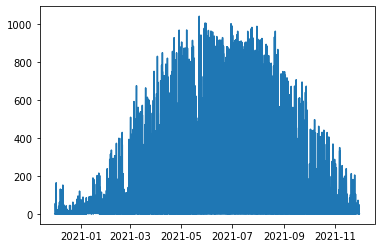

In [5]:
plt.plot(data.timestamp,data.radiation_flux)
plt.show()

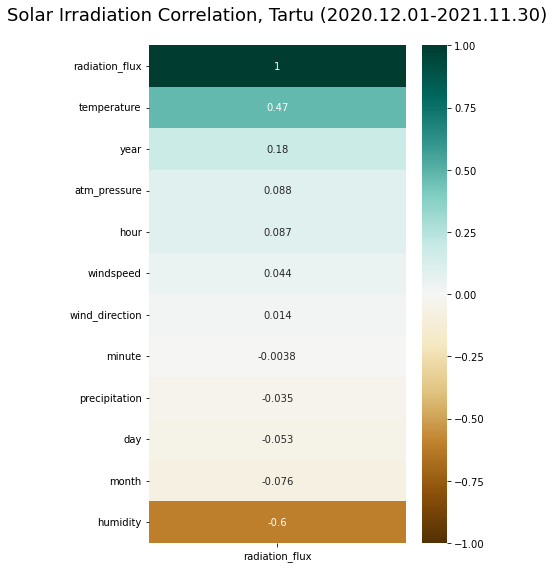

In [168]:
corr_table = data.corr()[['radiation_flux']].sort_values(by='radiation_flux', ascending=False)

plt.figure(figsize=(6, 8))
heatmap = sns.heatmap(corr_table, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Solar Irradiation Correlation, Tartu (2020.12.01-2021.11.30)', fontdict={'fontsize':18}, pad=25)
plt.tight_layout()
plt.savefig('corr.png', dpi=300)

In [7]:
def add_shifted_col(data,col,i):
    data[f'{col}_{i}'] = data[col].shift(-i)
    return data

In [31]:
def add_past_col(data,col,i):
    data[f'{col}_past{i}'] = data[col].shift(i)
    return data

# Training, validation, predicting

In [8]:
def train(train_data,columns,time,model):
    i = round(time/5)
    train_data = add_shifted_col(train_data,"radiation_flux",i)
    train_data = train_data.dropna()
    X_train = train_data[columns]
    y_train = train_data[f"radiation_flux_{i}"]
    model.fit(X_train,y_train)

def test(test_data,columns,time,model):
    i = round(time/5)
    test_data = add_shifted_col(test_data,"radiation_flux",i)
    test_data = test_data.dropna()
    X_test = test_data[columns]
    y_test = test_data[f"radiation_flux_{i}"]
    s = model.score(X_test,y_test)
    return s

In [9]:
train_data = get_weather_data(2018,1,1,2021,11,30)
train_data = cleansing(train_data)
test_data = get_weather_data(2021,12,1,2021,12,10)
test_data = cleansing(test_data)

In [10]:
columns = ['year', 'month', 'day', 'hour', 'minute', 'temperature',
        'humidity', 'atm_pressure', 'windspeed', 'wind_direction',
        'precipitation','radiation_flux']

In [11]:
time = 30 # how many minutes we would like to predict?
i = round(time/5)
train_data = add_shifted_col(train_data,"radiation_flux",i)
train_data = train_data.dropna()
X_train = train_data[columns]
y_train = train_data[f"radiation_flux_{i}"]
test_data = add_shifted_col(test_data,"radiation_flux",i)
test_data = test_data.dropna()
X_test = test_data[columns]
y_test = test_data[f"radiation_flux_{i}"]

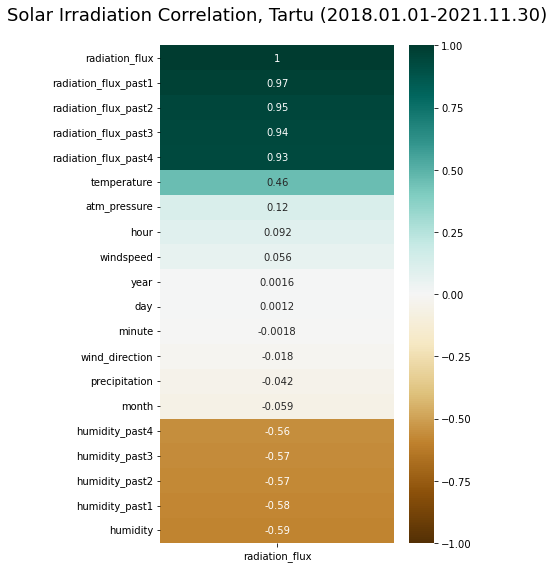

In [167]:
corr_table = X_train.corr()[['radiation_flux']].sort_values(by='radiation_flux', ascending=False)

plt.figure(figsize=(6, 8))
heatmap = sns.heatmap(corr_table, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Solar Irradiation Correlation, Tartu (2018.01.01-2021.11.30)', fontdict={'fontsize':18}, pad=25)
plt.tight_layout()
plt.savefig('corr.png', dpi=300)

In [12]:
RFR = RandomForestRegressor(n_estimators=50,random_state=0)
RFR.fit(X_train,y_train)
y_pred_RFR = RFR.predict(X_test)
RFR.score(X_test,y_test)

0.8894741159870502

In [13]:
ETR = ExtraTreesRegressor(n_estimators=50)
ETR.fit(X_train,y_train)
y_pred_ETR_50 = ETR.predict(X_test)
ETR.score(X_test,y_test)

0.8802027017586577

In [14]:
ETR = ExtraTreesRegressor(n_estimators=60)
ETR.fit(X_train,y_train)
y_pred_ETR_60 = ETR.predict(X_test)
ETR.score(X_test,y_test)

0.8882510585758624

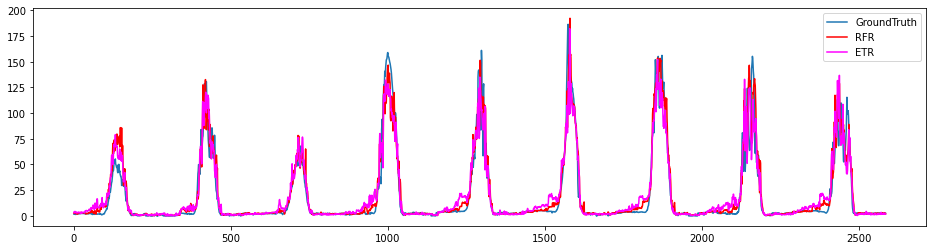

In [15]:
plt.figure(figsize=(16,4))
plt.plot(np.arange(X_test.shape[0]),y_test,label="GroundTruth")
plt.plot(np.arange(X_test.shape[0]),y_pred_RFR,color="red",label="RFR")
plt.plot(np.arange(X_test.shape[0]),y_pred_ETR_50,color="magenta",label="ETR")
plt.legend()
plt.show()

In [16]:
LinR = LinearRegression()
LinR.fit(X_train,y_train)
y_pred_LinR = LinR.predict(X_test)
LinR.score(X_test,y_test)

0.7376020828171157

In [17]:
LR = Ridge()
LR.fit(X_train,y_train)
y_pred_LR = LR.predict(X_test)
LR.score(X_test,y_test)

0.7376021071085503

In [18]:
LL = Lasso()
LL.fit(X_train,y_train)
y_pred_LL = LL.predict(X_test)
LL.score(X_test,y_test)

0.755831821201543

In [19]:
E = ElasticNet()
E.fit(X_train,y_train)
y_pred_E = E.predict(X_test)
E.score(X_test,y_test)

0.7557695426014602

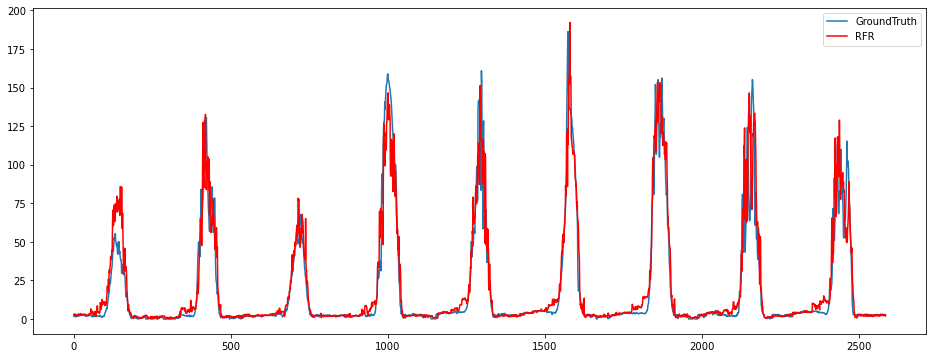

In [20]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(X_test.shape[0]),y_test,label="GroundTruth")
plt.plot(np.arange(X_test.shape[0]),y_pred_RFR,color="red",label="RFR")
#plt.plot(np.arange(X_test.shape[0]),y_pred_ETR_50,color="magenta",label="ETR")
#plt.plot(np.arange(X_test.shape[0]),y_pred_LinR,color="green",label="ETR")
#plt.plot(np.arange(X_test.shape[0]),y_pred_LR,color="orange",label="ETR")
#plt.plot(np.arange(X_test.shape[0]),y_pred_LL,color="black",label="ETR")
#plt.plot(np.arange(X_test.shape[0]),y_pred_E,color="yellow",label="ETR")
plt.legend()
plt.show()

In [21]:
rmse_RFR = np.sqrt(mean_squared_error(y_test, y_pred_RFR))
rmse_ETR_50 = np.sqrt(mean_squared_error(y_test, y_pred_ETR_50))
rmse_ETR_60 = np.sqrt(mean_squared_error(y_test, y_pred_ETR_60))
rmse_LinR = np.sqrt(mean_squared_error(y_test, y_pred_LinR))
rmse_LR = np.sqrt(mean_squared_error(y_test, y_pred_LR))
rmse_LL = np.sqrt(mean_squared_error(y_test, y_pred_LL))
rmse_E = np.sqrt(mean_squared_error(y_test, y_pred_E))
rmse_RFR,rmse_ETR_50,rmse_ETR_60,rmse_LinR,rmse_LR,rmse_LL,rmse_E


(11.651411114644912,
 12.13025804471372,
 11.715699849353825,
 17.95257375148943,
 17.95257292051145,
 17.31773380698426,
 17.319942234509316)

### The best number of estimators for ExtraTreesRegressor:

In [22]:
array = np.arange(10,60,step=5)

In [ ]:
scores = []
rmses = []
for n in array:
    ETR = ExtraTreesRegressor(n_estimators=n)
    ETR.fit(X_train,y_train)
    y_pred = ETR.predict(X_test)
    scores.append(ETR.score(X_test,y_test))
    rmses.append(mean_squared_error(y_test, y_pred,squared=False))

In [ ]:
np.argmax(scores), np.argmin(rmses), array[8]

In [24]:
ETR = ExtraTreesRegressor(n_estimators=50)
ETR.fit(X_train,y_train)
y_pred = ETR.predict(X_test)
print(ETR.score(X_test,y_test))
print(mean_squared_error(y_test, y_pred,squared=False))

0.878948489492221
12.193591297627089


### For learning future radiations make shifts:

In [25]:
for i in range(1,13):
    train_data = add_shifted_col(train_data,"radiation_flux",i)
    test_data = add_shifted_col(test_data,"radiation_flux",i)
train_data_shifts = train_data.dropna()
test_data_shifts = test_data.dropna()
train_data_shifts.head(1)
test_data_shifts.head(1)


,timestamp,temperature,humidity,atm_pressure,windspeed,wind_direction,precipitation,radiation_flux,year,month,...,radiation_flux_2,radiation_flux_3,radiation_flux_4,radiation_flux_5,radiation_flux_7,radiation_flux_8,radiation_flux_9,radiation_flux_10,radiation_flux_11,radiation_flux_12
0,2021-12-01,-7.501542,81.052555,982.982767,7.238821,286.398671,0.0,2.063729,2021,12,...,2.825529,2.575,2.857592,2.779076,1.670394,2.020584,1.53915,1.876869,1.65987,1.357387


### Train models, predict and calculate score and rmse for each shift:

In [26]:
ETR = ExtraTreesRegressor(n_estimators=45)
X_train = train_data_shifts[columns]
X_test = test_data_shifts[columns]
scores = []
rmses = []
predictions = pd.DataFrame()
for i in range(1,13):
    ETR.fit(X_train,train_data_shifts[f"radiation_flux_{i}"])
    y_test = test_data_shifts[f"radiation_flux_{i}"]
    scores.append(ETR.score(X_test,y_test))
    y_pred = ETR.predict(X_test)
    predictions[f"y_pred_{i}"] = y_pred
    rmses.append(mean_squared_error(y_test,y_pred,squared=False))

### Scores and RMSEs:

In [27]:
scores, rmses

([0.975138263742064,
  0.9419038466193378,
  0.9104730221225891,
  0.9118911939826007,
  0.899259484002971,
  0.8747290424432375,
  0.8579377186417582,
  0.8443915805490607,
  0.8211277739654625,
  0.8380969212727167,
  0.8330960493847085,
  0.8123347321581122],
 [5.536105818075666,
  8.462760620821573,
  10.505472240877799,
  10.42191616704745,
  11.14397145462237,
  12.426894767010339,
  13.233480899121082,
  13.84997040758989,
  14.84919929734991,
  14.127233797833783,
  14.34373561754928,
  15.209675022034329])

### Pedictions

In [28]:
predictions.sample(10)
predictions.iloc[-1,:]

y_pred_1     2.716740
y_pred_2     2.381575
y_pred_3     2.178586
y_pred_4     2.247445
y_pred_5     1.829012
y_pred_6     2.197948
y_pred_7     2.259183
y_pred_8     2.353972
y_pred_9     1.892246
y_pred_10    1.958807
y_pred_11    1.967287
y_pred_12    2.080258
Name: 2573, dtype: float64

# Newest model inspired by time series

### Create train and test sets

In [29]:
train_data = get_weather_data(2018,1,1,2021,11,30)
train_data = cleansing(train_data)
test_data = get_weather_data(2021,12,1,2021,12,10)
test_data = cleansing(test_data)

In [32]:
# add past values of radiation and humidity - values from 5 previous intervals
for i in range(1,5):
    train_data = add_past_col(train_data,"radiation_flux",i)
    train_data = add_past_col(train_data,"humidity",i)
    test_data = add_past_col(test_data,"radiation_flux",i)
    test_data = add_past_col(test_data,"humidity",i)
# add future values of radiation for teaching the model future values - currently 1 h ahead
for i in range(1,13):
    train_data = add_shifted_col(train_data,"radiation_flux",i)
    test_data = add_shifted_col(test_data,"radiation_flux",i)
train_data_past = train_data.dropna()
test_data_past = test_data.dropna()
test_data_past = test_data_past.reset_index(drop=True)
train_data_past = train_data_past.reset_index(drop=True)

In [35]:
print(train_data_past.columns)

Index(['timestamp', 'temperature', 'humidity', 'atm_pressure', 'windspeed',
       'wind_direction', 'precipitation', 'radiation_flux', 'year', 'month',
       'day', 'hour', 'minute', 'radiation_flux_past1', 'humidity_past1',
       'radiation_flux_past2', 'humidity_past2', 'radiation_flux_past3',
       'humidity_past3', 'radiation_flux_past4', 'humidity_past4',
       'radiation_flux_1', 'radiation_flux_2', 'radiation_flux_3',
       'radiation_flux_4', 'radiation_flux_5', 'radiation_flux_6',
       'radiation_flux_7', 'radiation_flux_8', 'radiation_flux_9',
       'radiation_flux_10', 'radiation_flux_11', 'radiation_flux_12'],
      dtype='object')


In [36]:
test_data_past.head(1)

,timestamp,temperature,humidity,atm_pressure,windspeed,wind_direction,precipitation,radiation_flux,year,month,...,radiation_flux_3,radiation_flux_4,radiation_flux_5,radiation_flux_6,radiation_flux_7,radiation_flux_8,radiation_flux_9,radiation_flux_10,radiation_flux_11,radiation_flux_12
4,2021-12-01 00:20:00,-7.547275,82.254505,983.0681,6.793904,284.395862,0.0,2.857592,2021,12,...,1.670394,2.020584,1.53915,1.876869,1.65987,1.357387,2.031108,2.235292,2.155031,2.213202


In [43]:
# columns for X sets
columns = ['temperature', 'humidity', 'atm_pressure', 'windspeed',
       'wind_direction', 'precipitation', 'radiation_flux', 'year', 'month',
       'day', 'hour', 'minute', 'radiation_flux_past1', 'humidity_past1',
       'radiation_flux_past2', 'humidity_past2', 'radiation_flux_past3',
       'humidity_past3', 'radiation_flux_past4', 'humidity_past4']

X_train = train_data_past[columns]
X_test = test_data_past[columns]

### Create models for each future inverval and train models with relevant sets

In [46]:
models = []
scores = []
for i in range(1,13):
    y_train = train_data_past[f"radiation_flux_{i}"]
    y_test = test_data_past[f"radiation_flux_{i}"]
    ETR = ExtraTreesRegressor(n_estimators=50)
    ETR.fit(X_train,y_train)
    scores.append(ETR.score(X_test,y_test))
    models.append(ETR)
    print(scores[i-1])

0.9797726910276078
0.9556454034435278
0.9331829492139246
0.9196128736455773
0.9009952170543951
0.8971103122751094
0.8798269333399616
0.8674215830141084
0.8587886192514244
0.8571014736163578
0.8458769613021613
0.848857206506902


### Make predictions for test set and calculate RMSEs

In [49]:
rmses = []
predictions = pd.DataFrame()
for i in range(1,13):
    y_pred = models[i-1].predict(X_test)
    predictions[f"y_pred{i}"] = y_pred
    y_test = test_data_past[f"radiation_flux_{i}"]
    rmses.append(mean_squared_error(y_test,y_pred,squared=False))
    

In [48]:
rmses

[4.9919806082701825,
 7.392192670183956,
 9.072903694714553,
 9.951629813220265,
 11.044060233778952,
 11.258624599118118,
 12.167523418268617,
 12.780048862888862,
 13.189489639767775,
 13.268002270005653,
 13.779218015993322,
 13.645314495997086]

In [50]:
predictions

,y_pred1,y_pred2,y_pred3,y_pred4,y_pred5,y_pred6,y_pred7,y_pred8,y_pred9,y_pred10,y_pred11,y_pred12
0,2.948760,2.846344,3.263786,2.789910,3.804539,2.736336,2.493054,4.647907,3.607108,4.454553,2.940407,3.781062
1,2.897512,2.575775,2.704047,2.702873,3.471625,2.543340,2.847916,3.861482,2.752155,5.958068,2.888727,3.699651
2,2.386527,2.413829,2.298390,2.256701,2.616404,2.221911,4.937756,4.777074,3.196380,4.655298,2.532669,3.211341
3,1.931846,1.942604,2.274744,2.383420,2.823844,2.314755,4.259645,3.450679,2.703591,4.658439,2.566109,2.858209
4,2.061459,2.138902,2.001740,2.270071,2.964077,2.154459,3.398284,4.823276,2.828761,4.750223,2.461336,3.004927
...,...,...,...,...,...,...,...,...,...,...,...,...
2571,2.761435,2.831650,3.161372,3.215239,2.737784,2.697552,2.951876,2.950274,2.705094,2.952023,2.545530,2.738095
2572,2.669190,2.561320,2.538813,2.819077,2.807839,2.925164,3.054375,2.788993,2.979061,2.874014,2.847028,2.828006
2573,2.900350,2.986705,3.430965,3.459218,2.980577,2.545610,3.191096,2.878300,2.768597,2.970454,2.478366,3.068747
2574,2.794286,3.095598,3.278409,3.278636,3.061117,2.793234,3.480496,3.001695,2.765753,3.188733,2.905928,3.147712


In [65]:
results = pd.concat([test_data_past.iloc[:,:8],predictions],axis=1)
results.head(10)


,timestamp,temperature,humidity,atm_pressure,windspeed,wind_direction,precipitation,radiation_flux,y_pred1,y_pred2,y_pred3,y_pred4,y_pred5,y_pred6,y_pred7,y_pred8,y_pred9,y_pred10,y_pred11,y_pred12
0,2021-12-01 00:20:00,-7.547275,82.254505,983.068100,6.793904,284.395862,0.0,2.857592,2.948760,2.846344,3.263786,2.789910,3.804539,2.736336,2.493054,4.647907,3.607108,4.454553,2.940407,3.781062
1,2021-12-01 00:25:00,-7.573656,82.672797,983.066467,6.327816,285.605012,0.0,2.779076,2.897512,2.575775,2.704047,2.702873,3.471625,2.543340,2.847916,3.861482,2.752155,5.958068,2.888727,3.699651
2,2021-12-01 00:30:00,-7.563444,82.850706,983.077767,6.223850,284.032634,0.0,1.765567,2.386527,2.413829,2.298390,2.256701,2.616404,2.221911,4.937756,4.777074,3.196380,4.655298,2.532669,3.211341
3,2021-12-01 00:35:00,-7.544018,82.670375,983.054567,6.760767,287.654814,0.0,1.670394,1.931846,1.942604,2.274744,2.383420,2.823844,2.314755,4.259645,3.450679,2.703591,4.658439,2.566109,2.858209
4,2021-12-01 00:40:00,-7.498769,82.198527,983.067200,6.619931,286.126767,0.0,2.020584,2.061459,2.138902,2.001740,2.270071,2.964077,2.154459,3.398284,4.823276,2.828761,4.750223,2.461336,3.004927
5,2021-12-01 00:45:00,-7.515420,82.669004,983.105533,6.494979,284.590108,0.0,1.539150,1.814094,1.798410,2.194300,1.896891,2.295341,2.004900,3.757364,3.415263,2.637769,3.478590,2.331390,2.521191
6,2021-12-01 00:50:00,-7.507572,82.765673,983.156944,6.193631,286.597443,0.0,1.876869,2.120960,2.147812,2.131234,2.092055,2.235139,1.751888,2.519329,2.987298,2.441263,3.389301,1.994049,2.514766
7,2021-12-01 00:55:00,-7.493664,82.704415,983.160533,6.739547,283.219738,0.0,1.659870,1.685343,2.047338,2.009087,2.040515,2.472824,1.881578,3.324896,3.465222,2.562658,3.259447,2.010201,2.398892
8,2021-12-01 01:00:00,-7.478593,82.778462,983.155833,6.101491,285.791879,0.0,1.357387,1.705959,1.618085,1.807478,1.971504,2.034559,1.827190,3.663040,2.902523,2.328014,3.292939,2.101037,2.349566
9,2021-12-01 01:05:00,-7.491165,83.464286,983.201633,6.064414,286.012739,0.0,2.031108,1.966026,2.229838,1.875755,1.861077,2.205733,2.050470,2.734554,4.152830,3.122489,2.552451,1.920399,2.275828


### Visualizing per intervals

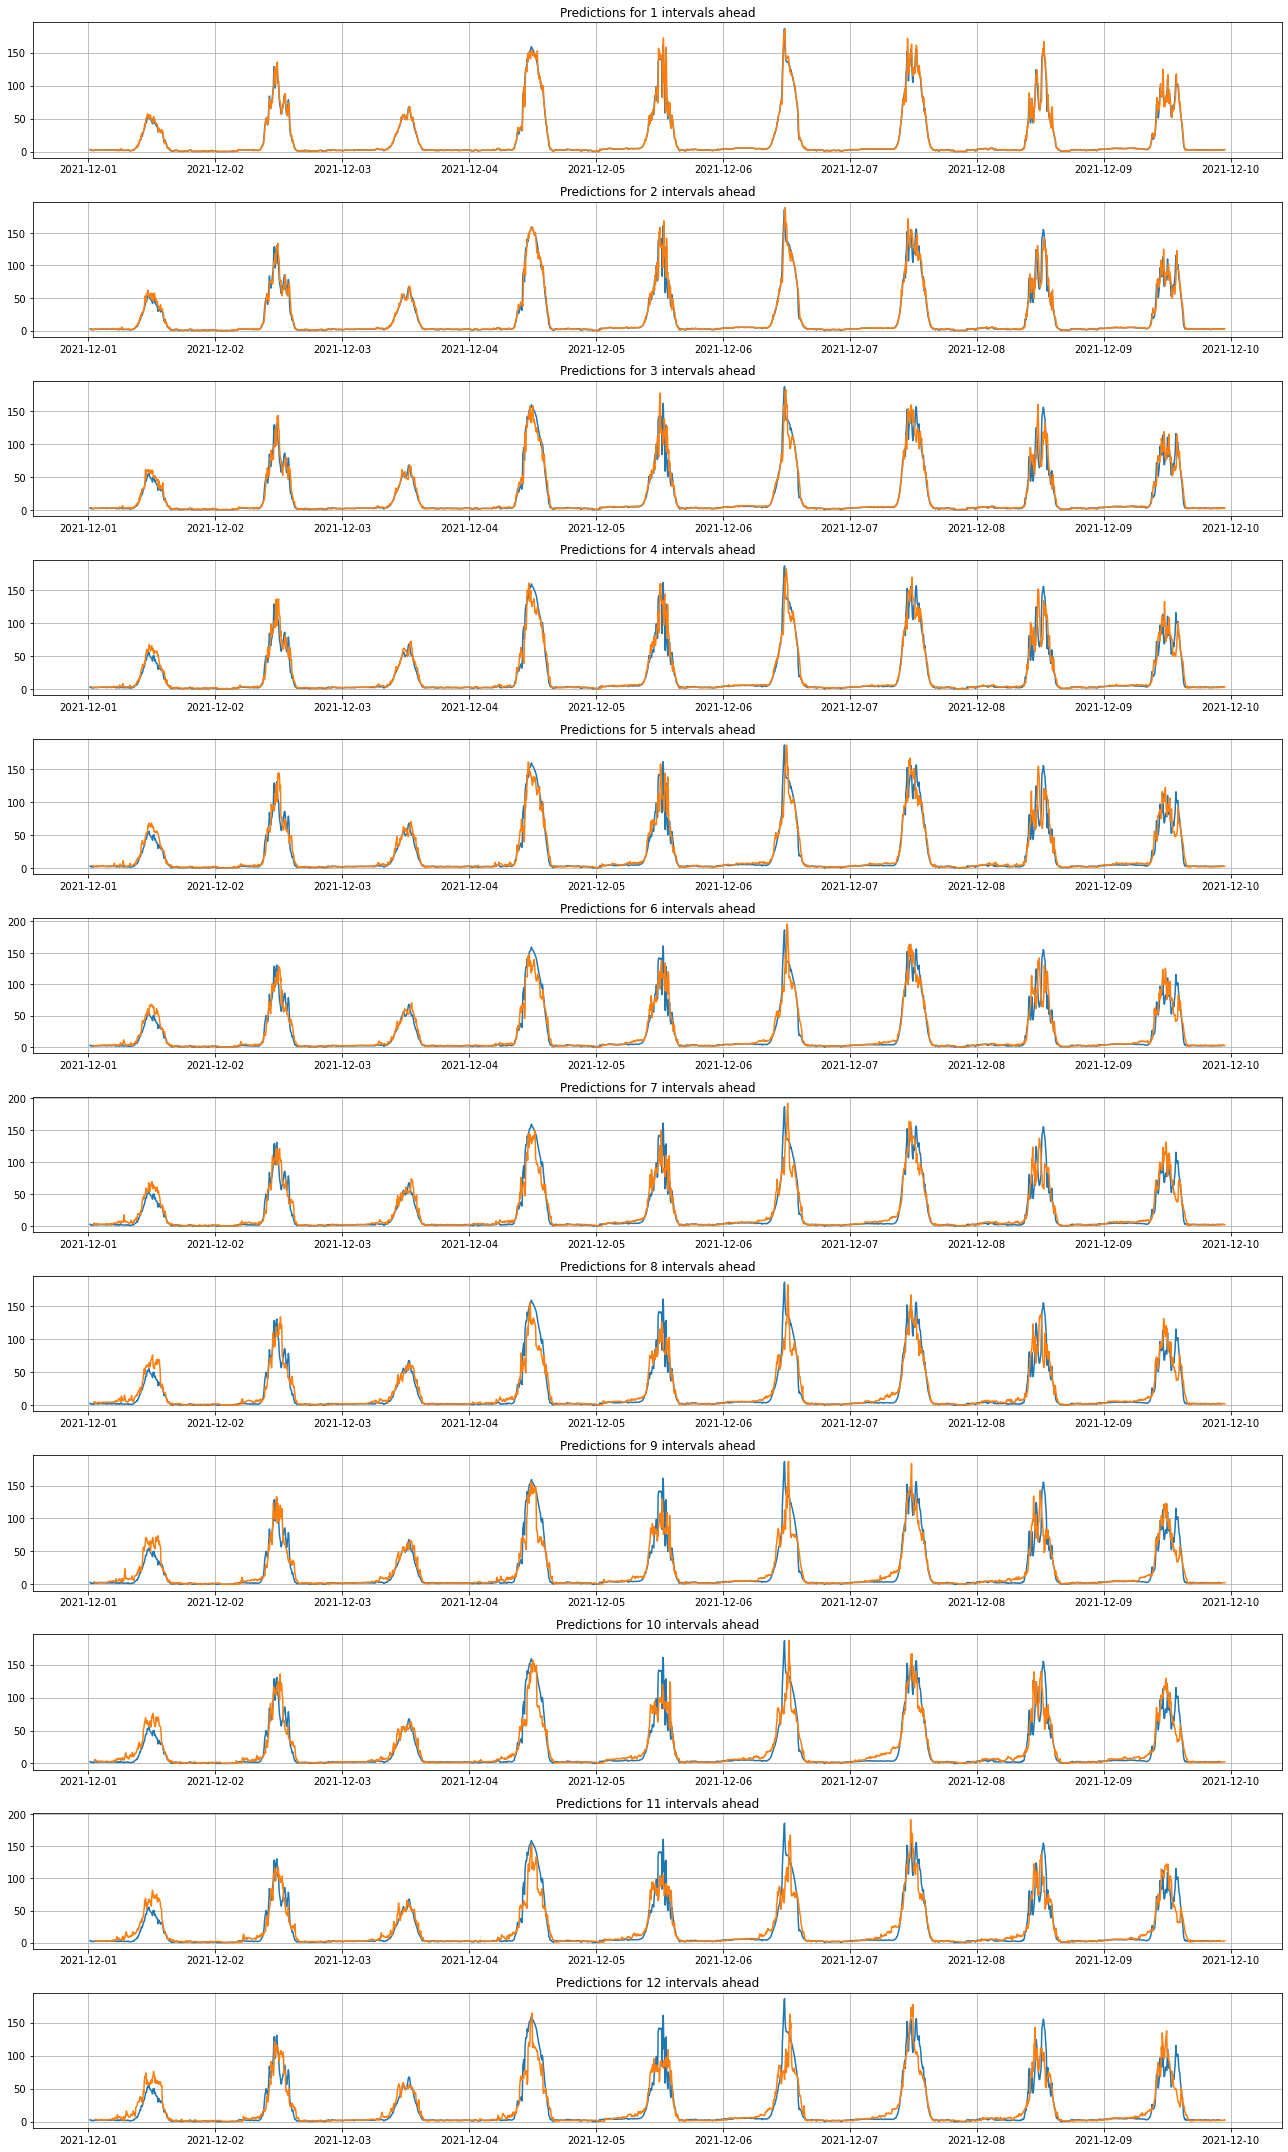

In [109]:

fig, axs = plt.subplots(12, 1, figsize=(18,30))
for i in range(1,13):
    axs[i-1].plot(results.timestamp[:-i],results.radiation_flux[:-i])
    axs[i-1].plot(results.timestamp[i:],results[f"y_pred{i}"][:-i])
    axs[i-1].set_title(f"Predictions for {i} intervals ahead")
    axs[i-1].grid(True)
fig.tight_layout()
plt.show()

### Visualize the 1 hour prediction with test

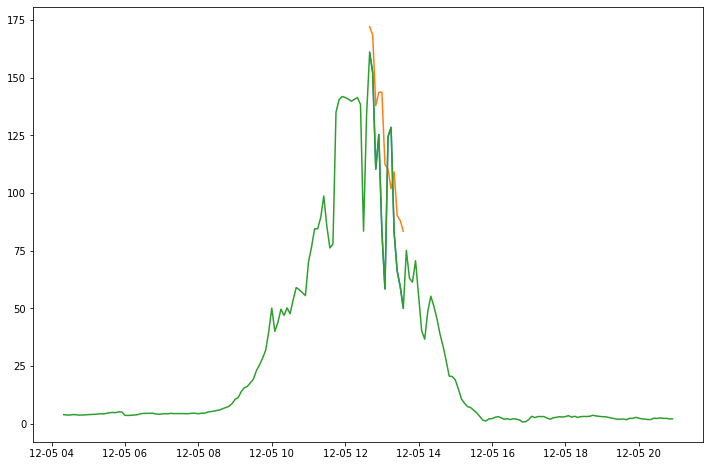

([160.969675875,
  152.019362097,
  110.364122253,
  125.335578786,
  83.1783871416,
  58.4339568631,
  124.405239907,
  128.43287433,
  82.9286429636,
  66.1888765069,
  59.4207718439,
  50.093499674],
 [172.07868617732598,
  168.394710360116,
  137.855564347622,
  143.639640548584,
  143.70429413261,
  112.371786418322,
  110.32264945642997,
  101.86911531521997,
  109.09594795394001,
  90.201377732074,
  88.083062129418,
  83.419161403002])

In [150]:
i=1300
test_list = list(results.iloc[i:i+12,7])
whole_test = list(results.iloc[i-100:i+100,7])
whole_time = list(results.iloc[i-100:i+100,0])
pred_list = list(results.iloc[i,8:])
time_list = list(results.iloc[i:i+12,0])
plt.figure(figsize=(12,8))
plt.plot(time_list,test_list)
plt.plot(time_list,pred_list)
plt.plot(whole_time,whole_test)
plt.plot()
plt.show()
test_list, pred_list

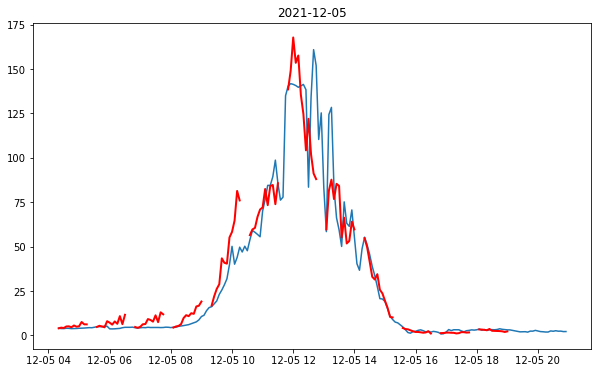

In [163]:
plt.figure(figsize=(10,6))
j=1200
whole_test = list(results.iloc[j:j+200,7])
whole_time = list(results.iloc[j:j+200,0])
date_title = results.iloc[j+100,0].date()
plt.plot(whole_time,whole_test)
for i in np.arange(start=0,stop=180,step=15):
    pred_list = list(results.iloc[j+i,8:])
    time_list = list(results.iloc[j+i:j+i+12,0])
    plt.plot(time_list,pred_list,color="red",linewidth=2)
plt.title(f"{date_title}")
plt.show()

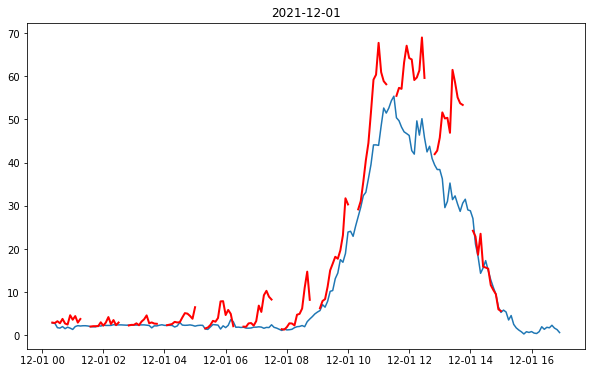

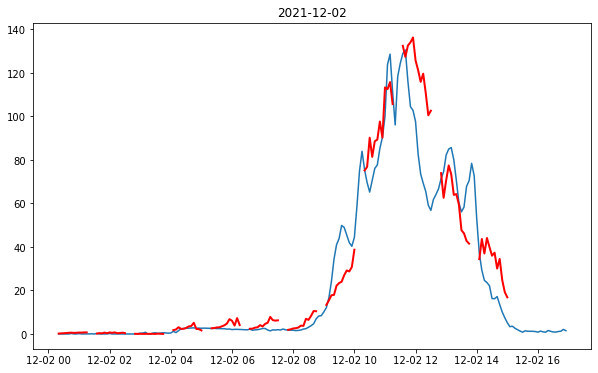

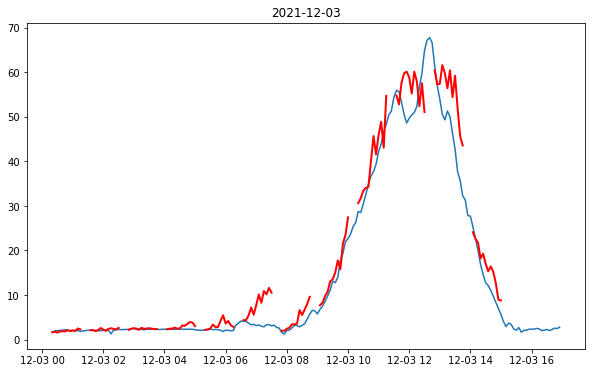

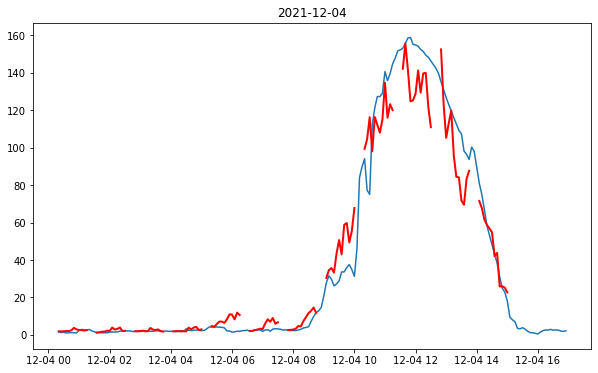

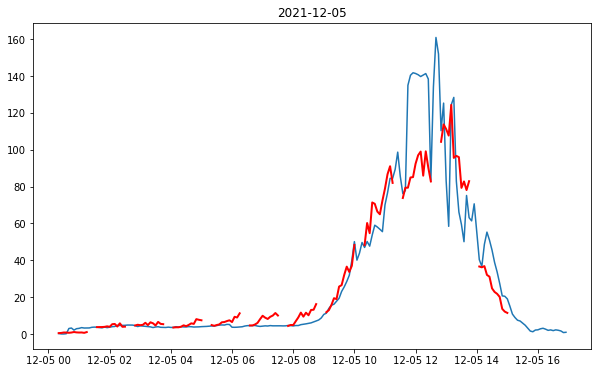

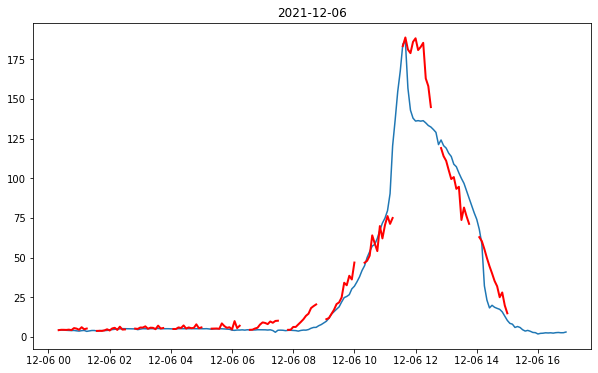

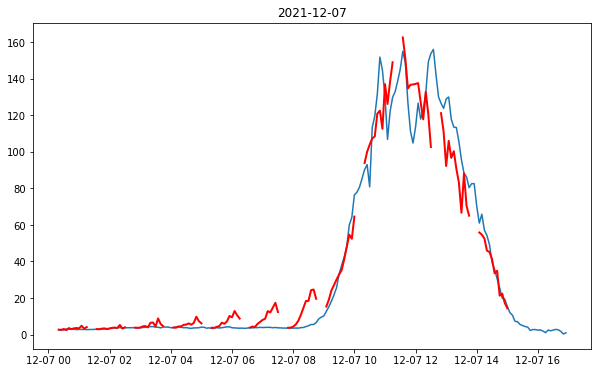

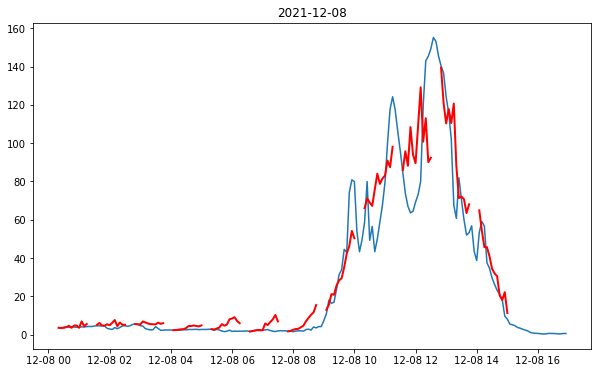

In [165]:
for j in np.arange(start = 0, stop = 2160, step = 288):
    plt.figure(figsize=(10,6))
    whole_test = list(results.iloc[j:j+200,7])
    whole_time = list(results.iloc[j:j+200,0])
    date_title = results.iloc[j+100,0].date()
    plt.plot(whole_time,whole_test)
    for i in np.arange(start=0,stop=180,step=15):
        pred_list = list(results.iloc[j+i,8:])
        time_list = list(results.iloc[j+i:j+i+12,0])
        plt.plot(time_list,pred_list,color="red",linewidth=2)
    plt.title(f"{date_title}")
    plt.show()

In [130]:
results.radiation_flux.max()

186.328234561

In [131]:
mean_residual = []
median_residual = []
std_residual = []
min_residual = []
max_residual = []
for i in range(results.shape[0]-12):
    test_list = list(results.iloc[i:i+12,7])
    pred_list = list(results.iloc[i,8:])
    residuals = []
    for j in range(12):
        if test_list[j]==0: residuals.append(np.abs(1 - pred_list[j])/1)
        else: residuals.append(np.abs(test_list[j] - pred_list[j])/test_list[j])
    mean_residual.append(np.mean(residuals))
    median_residual.append(np.median(residuals))
    std_residual.append(np.std(residuals))
    min_residual.append(np.min(residuals))
    max_residual.append(np.max(residuals))

In [142]:
np.min(mean_residual), np.max(mean_residual), np.mean(mean_residual)

(0.03498192393212683, 34.16750407670988, 0.7231193503197304)

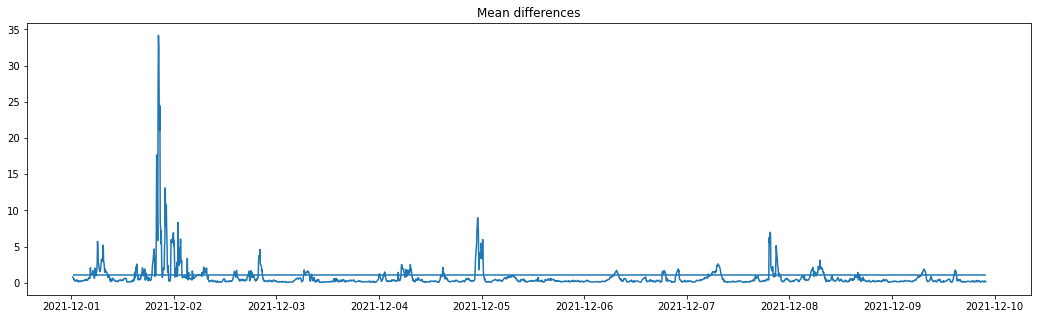

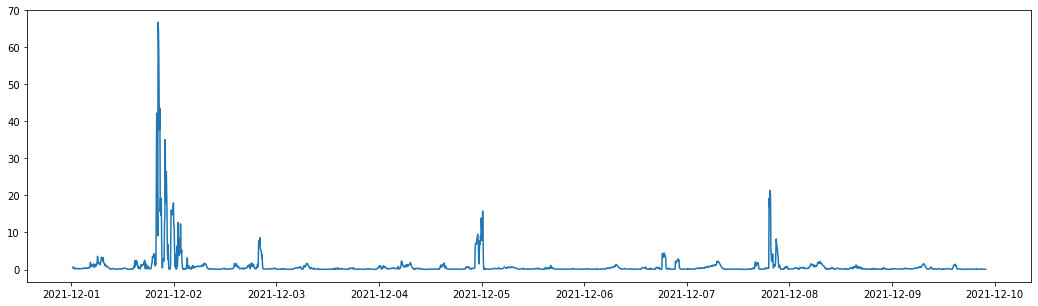

In [140]:
plt.figure(figsize=(18,5))
plt.plot(results.iloc[:results.shape[0]-12,0],mean_residual)
plt.hlines(y=1,xmin=results.iloc[0,0],xmax=results.iloc[results.shape[0]-13,0])
plt.title("Mean differences")
plt.show()
plt.figure(figsize=(18,5))
plt.plot(results.iloc[:results.shape[0]-12,0],std_residual)
plt.show()

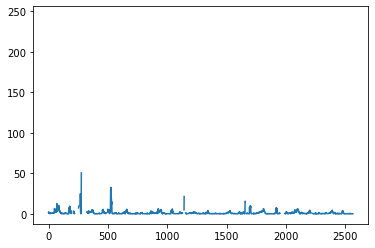

In [121]:
plt.plot(range(results.shape[0]-12),max_residual)
plt.show()